## Causality

Pada bab ini akan dijelaskan mengapa menambah variabel prediktor (feature) tidak selalu menjadi solusi dalam memprediksi variabel terobserrvasi.

#### Multicoliniearity

Pada bab sebelumnya, disajikan data tetang profil primata dan energi dalam susu. Apakah semua kolom dapat diperlakukan sebagai variabel prediktor? Ada beberapa hal yang perlu diperhatikan. Pertama adalah tentang colinearity.

Colinearity berarti adanya asosiasi yang kuat antara dua atau lebih varibel prediktor. Konsekuensi dari hal ini adalah pada distribusi posterior tidak terlihat pengaruh pengaruh variabel colinear dengan variebl terobservasi.

Colinearity dapat dilihat pada contoh berikut

In [78]:
import numpy as np
from scipy.stats import norm, uniform, binom, bernoulli
import pandas as pd
import pymc3 as pm
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import logging
logger = logging.getLogger('pymc3')
logger.setLevel(logging.ERROR)

In [5]:
np.random.seed(7)

n_individual = 100
height = norm.rvs(size=n_individual, loc = 10, scale = 2)
leg_prop = uniform.rvs(size=n_individual,loc=0.4, scale=0.1)
leg_left = height * leg_prop + norm.rvs(size=n_individual, loc=0, scale=.02)
leg_right = height * leg_prop + norm.rvs(size=n_individual, loc=0, scale=.02)

df = pd.DataFrame({})
df['height'] = height
df['leg_left'] = leg_left
df['leg_right'] = leg_right

For some reason this model is not convergence when including both leg
```python
with pm.Model() as m61:
    alpha = pm.Normal('alpha', mu = 10, sd = 100)
    beta_r = pm.Normal('beta_r', mu = 2, sd = 10)
    beta_l = pm.Normal('beta_l', mu = 2, sd = 10)
    sigma = pm.Exponential('sigma', lam = 1)
    mu = pm.Deterministic('mu', alpha + beta_r * df['leg_right'] + beta_l * df['leg_left'])
    result = pm.Normal('result', mu = mu, sd = sigma, observed=df['height'])
    
with m61:
    trace_m61 = pm.sample(1000, tune=1000)
    df_trace_m61 = pm.trace_to_dataframe(trace_m61)
```

sns.distplot(df_trace_m61['alpha'])
sns.distplot(df_trace_m61['beta_l'])
sns.distplot(df_trace_m61['beta_r'])
sns.distplot(df_trace_m61['sigma'])

df_trace_m61[["alpha", "beta_r", "beta_l","sigma"]].describe()

y_axis = [df_trace_m61['alpha'].mean() + df_trace_m61['beta_r'].mean() * i for i in np.sort(df['leg_right'])]
plt.scatter(df['leg_right'], df['height'])
plt.scatter(df['leg_left'], df['height'])
plt.plot(np.sort(df['leg_right']), y_axis)

Masalah yang dicatumkan pada buku tidak dapat direplikasi

Inti dari colinearity adalah adanya efek saling meniadakan antara kedua variabel yang colinear. Semisal pada kasus contoh kaki yang ditampilkan adalah model linear regresi mengaggap bahwa apabila nilai kaki berbanding terbalik dengan kaki lainya. Ini dapat dibuktikan dengan menggunakan model single variate salah satu kaki. Jumlah gradient pada multivariate akan sama dengan nilai gradient pada model single variate terlepas dari kaki mana yang diambil sebagai prediktor. 

Ini akan berdampak pada pengambilan kesimpulan karena model linear meanggap bahwa variabel colinear berbanding terbalik antar satu dengan yang lain. Secara model tidak ada masalah karena dalam proses pencarian model terbaik hal tersebut harus terjadi. Ini mendorong para pembuat model mengenal variabel terlebih dahulu sebelum membangun model dari variabel-variabel tersedia.

In [6]:
raw_url = "https://raw.githubusercontent.com/pymc-devs/resources/master/Rethinking/Data/milk.csv"
df = pd.read_csv(raw_url, sep=';')
print(df.shape)
df.head()

(29, 8)


,clade,species,kcal.per.g,perc.fat,perc.protein,perc.lactose,mass,neocortex.perc
0,Strepsirrhine,Eulemur fulvus,0.49,16.60,15.42,67.98,1.95,55.16
1,Strepsirrhine,E macaco,0.51,19.27,16.91,63.82,2.09,NaN
2,Strepsirrhine,E mongoz,0.46,14.11,16.85,69.04,2.51,NaN
3,Strepsirrhine,E rubriventer,0.48,14.91,13.18,71.91,1.62,NaN
4,Strepsirrhine,Lemur catta,0.60,27.28,19.50,53.22,2.19,NaN


In [7]:
def standarize(df, cols, destination):
    df[destination] = (df[cols] - df[cols].mean()) / df[cols].std()
    
standarize(df, 'kcal.per.g', 'K')
standarize(df, 'perc.fat', 'F')
standarize(df, 'perc.lactose', 'L')

In [8]:
with pm.Model() as m61:
    alpha = pm.Normal('alpha', mu=0, sd=.2)
    beta = pm.Normal('beta', mu=0, sd=.5)
    mu = pm.Deterministic('mu', alpha + beta * df['F'])
    sigma = pm.Exponential('sigma', lam=1)
    result = pm.Normal('result', mu=mu, sd=sigma, observed=df['K'])

with m61:
    trace_m61 = pm.sample(1000, tune=1000)
    df_trace_m61 = pm.trace_to_dataframe(trace_m61)

with pm.Model() as m62:
    alpha = pm.Normal('alpha', mu=0, sd=.2)
    beta = pm.Normal('beta', mu=0, sd=.5)
    mu = pm.Deterministic('mu', alpha + beta * df['L'])
    sigma = pm.Exponential('sigma', lam=1)
    result = pm.Normal('result', mu=mu, sd=sigma, observed=df['K'])

with m62:
    trace_m62 = pm.sample(1000, tune=1000)
    df_trace_m62 = pm.trace_to_dataframe(trace_m62)

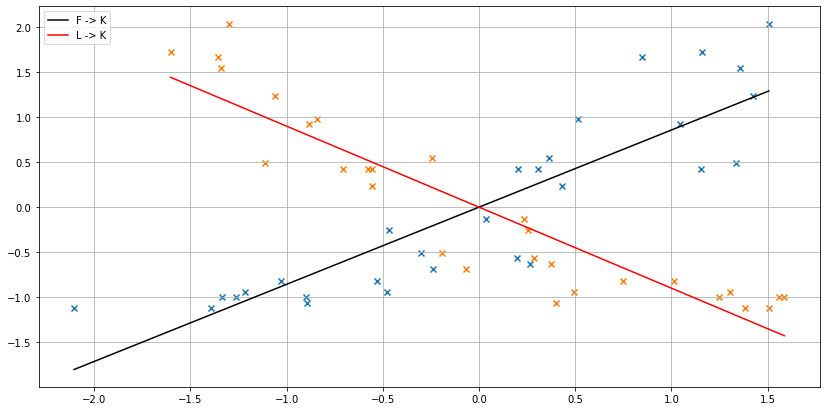

In [9]:
fig, ax = plt.subplots(nrows=1, ncols=1)
fig.set_figwidth(14)
fig.set_figheight(7)

ax.scatter(df['F'], df['K'], marker='x')
x_axis = df.sort_values('F')
y_axis = df_trace_m61['alpha'].mean() + df_trace_m61['beta'].mean() * x_axis['F']
ax.plot(x_axis['F'], y_axis, color='k', label='F -> K')

ax.scatter(df['L'], df['K'], marker='x')
x_axis = df.sort_values('L')
y_axis = df_trace_m62['alpha'].mean() + df_trace_m62['beta'].mean() * x_axis['L']
ax.plot(x_axis['L'], y_axis, color='r', label='L -> K')
ax.legend()
ax.grid(b=True)

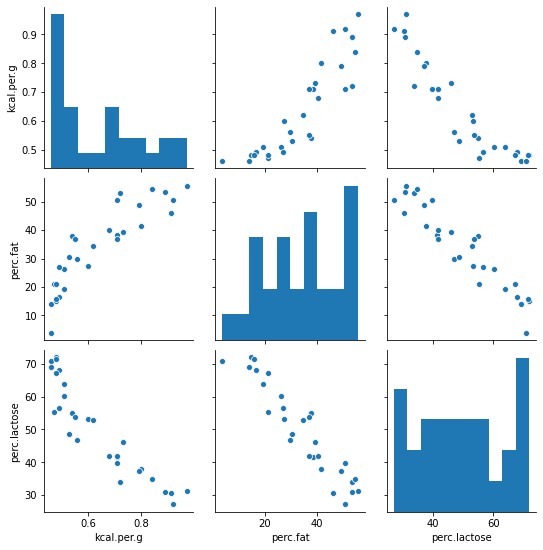

In [10]:
sns.pairplot(df[['kcal.per.g', 'perc.fat', 'perc.lactose']])

Seperti yang dapat dilihat baik dari regresi dan plot pasangan bahwa nilai persenan lactose berbanding terbalik dengan energi per gram sedangkan untuk lemak berbanding lurus. Pada plot regresi diatas dapat dilihat juga bahwa gradient cendrung saling meniadakan (apabila dijumlahkan nilai gradient pada setiap x untuk kedua variabel tersebut hasilnya akan menjadi nol. Ini memliki kasus yang berbeda dengan kasus panjang kaki sebelumnya. Selanjutnya akan dibuatkan model multivariate yang melibatkan keduanya. 

In [11]:
with pm.Model() as m63:
    alpha = pm.Normal('alpha', mu=0, sd=.2)
    beta_f = pm.Normal('beta_f', mu=0, sd=.5)
    beta_l = pm.Normal('beta_l', mu=0, sd=.5)
    mu =pm.Deterministic('mu', alpha + beta_f * df['F'] + beta_l * df['L'])
    sigma = pm.Exponential('sigma', lam=1)
    result = pm.Normal('result', mu=mu, sd=sigma, observed=df['K'])

with m63:
    trace_m63 = pm.sample(1000, tune=1000)
    df_trace_m63 = pm.trace_to_dataframe(trace_m63)

In [12]:
print("F -> K\n", df_trace_m61[["alpha", "beta", "sigma", "mu__0"]].describe().loc[['mean', 'std']].round(2), "\n")
print("L -> K\n", df_trace_m62[["alpha", "beta", "sigma", "mu__0"]].describe().loc[['mean', 'std']].round(2), "\n")
print("F & L => K\n", df_trace_m63[["alpha", "beta_f", "beta_l","sigma", "mu__0"]].describe().loc[['mean', 'std']].round(2), "\n")

F -> K
       alpha  beta  sigma  mu__0
mean  -0.00  0.86   0.48  -1.04
std    0.09  0.09   0.07   0.14 

L -> K
       alpha  beta  sigma  mu__0
mean  -0.00 -0.90   0.41  -1.18
std    0.07  0.08   0.06   0.13 

F & L => K
       alpha  beta_f  beta_l  sigma  mu__0
mean  -0.00    0.26   -0.66   0.41  -1.18
std    0.07    0.20    0.20   0.06   0.13 



Bisa dilihat pada perbandingan antara gradient saat pemodelan single variable dan mutlivariate. Pada multivariate, gradient untuk lemak adalah 0.27 dengan standar deviasi 0.21 sedangkan pada model single variate untuk lemak gradien bererata 0.86 dengan standari deviasi 0.09. Tidak hanya untuk lemak, untuk lactose pun demikian. Nilai rerata absolut pun berkurang dan nilai standar deviasi bertambah.

Ini menandakan bahwa saat sudah mengetahu satu variable, tidak ada informasi yang diperoleh saat menambah variabel colinear yang lain. Ini juga bisa diambil dari nilai `mu__0` yang hanya terjadi sedikit perubahan.

Kemungkinan terjadi pertukaran nilai lemak dan laktose yang dapat dituliskan sebagai

$$C = F + L + \epsilon$$

$C$ adalah sebuah konstanta yang dalam kasus ini adalah persenan yang tentunya ada error dalam nilai $C$ yang diwakili oleh variable $\epsilon$. Nilai $C$ pada suatu primata selalu sama sehingga apabila nilai lemak $F$ pada susunya tinggi maka nilai laktosa $L$ akan turun agar nilai $C$ tetap konstan.

Variable $C$ ini apa yang Pak Richard sebutkan sebagai variabel tidak teridentifikasi (non-identifiable) karena tidak tersedia dalam data. Variabel ini memiliki lingkaran dalam DAG yang Pak Richard buat.

Secara umum, tidak ada jaminan bahwa data yang tersedia memiliki informasi yang cukup tentang variable yang diuji. Ini pentingnya membandingkan antara prior dan posterior karena penguji/peneliti dapat melihat pengaruh data terhadap prior. Apabila posterior memiliki properti yang sama dengan prior, data yang diberikan tidak memberikan informasi apapun yang dapat memperbarui kepercayaan terhadap model.

> **Takeaway**   
Memperhatikan colinearitas antara variabel penting supaya menghindari asumsi yang salah dan membangun model yang akurat. Semakin banyak variabel yang terlibat, maka semakin banyak variabel yang harus dievaluasi colinearitasnya sebelum membangun model.

#### Post Treatment Bias

Ada kekahawatiran tentang menghilangkan suatu variabel prediktor akan berujung pada kesalahan pada pengambilan kesimpulan. Hal ini biasa dinamakan **Omitted variable bias**. Sebaliknya juga ada kehawatiran tentang menambahkan suatu variabel prediktor akan berujung pada kesalahan pada pengambilan kesimpulan. Hal ini disebut **Post treatment bias**. 

Asumsilah ada penelitian tentang pengaruh perbedaan tanah terhadap tumbuh kembang suatu tumbuhan. Tanah yang dicari adalah tanah yang memiliki kemampuan mengusir jamur karena ada kesimpulan bahwa jamur menhambat tumbuh tumbuhan.

Ada empat variable yang akan ditinjau. Awal tinggi tumbuhan, akhir tinggi tumbuhan, perlakuan ke tanah, dan kehadiran jamur. Variable tinggi tumbuhan akan menjadi variabel terobservasi. Mari dibuat modelnya

In [100]:
n_plants = 100
init_height = norm.rvs(size = n_plants, loc=10, scale=2)
treatment = np.repeat([0,1], repeats = n_plants // 2)
fungus = binom.rvs(1, 0.5 - treatment * .4, size = n_plants)
final_height = init_height + norm.rvs(size=n_plants, loc=5-3 * fungus)

In [101]:
df = pd.DataFrame({
    "init_height": init_height,
    "treatment": treatment,
    "fungus": fungus,
    "final_height": final_height
})

df.describe().loc[["mean", "std"]].round(2)

,init_height,treatment,fungus,final_height
mean,10.02,0.5,0.30,14.12
std,2.05,0.5,0.46,2.84


Pada model dummy yang dibuat, setngah dari sampel akan diberikan penanganan untuk jamur dan setengah sisanya dibiarkan saja. Pak Richard berargumen bahwa variabel fungus akan menybabkan post treatment bias. Ini dikarenakan fungus diukur bersama variabel yang diprediksi yaitu tinggi final dari tumbuhan.

In [102]:
with pm.Model() as m64:
    p = pm.Lognormal('p', mu=0, sd=.25)
    mu = pm.Deterministic('mu',  p * df['init_height'])
    sigma = pm.Exponential('sigma', lam=1)
    result = pm.Normal('result', mu=mu, sd=sigma, observed=df['final_height'])

with m64:
    trace_m64 = pm.sample(1000, tune=1000)
    df_trace_m64 = pm.trace_to_dataframe(trace_m64)

In [103]:
df_trace_m64.describe()['p'].loc[['mean', 'std']]

mean    1.392859
std     0.019952
Name: p, dtype: float64

In [104]:
def generate_trace_df(model):
    with model:
        trace = pm.sample(1000, tune=1000)
        return pm.trace_to_dataframe(trace)

with pm.Model() as m65:
    alpha = pm.Lognormal('alpha', mu=0, sd=.25)
    beta_t = pm.Normal('beta_t', mu=0, sd=.5)
    beta_f = pm.Normal('beta_f', mu=0, sd=.5)
    p = pm.Deterministic('p',  alpha + beta_t * df['treatment'] + beta_f * df['fungus'])
    mu = p * df['init_height']
    sigma = pm.Exponential('sigma', lam=1)
    result = pm.Normal('result', mu=mu, sd=sigma, observed=df['final_height'])

df_trace_m65 = generate_trace_df(m65)

In [105]:
df_trace_m65.describe()[['alpha', 'beta_t', 'beta_f', 'p__0']].loc[['mean', 'std']].round(2)

,alpha,beta_t,beta_f,p__0
mean,1.49,-0.03,-0.30,1.19
std,0.03,0.03,0.04,0.03


In [106]:
with pm.Model() as m66:
    alpha = pm.Lognormal('alpha', mu=0, sd=.25)
    beta_t = pm.Normal('beta_t', mu=0, sd=.5)
    p = pm.Deterministic('p',  alpha + beta_t * df['treatment'])
    mu = p * df['init_height']
    sigma = pm.Exponential('sigma', lam=1)
    result = pm.Normal('result', mu=mu, sd=sigma, observed=df['final_height'])

df_trace_m66 = generate_trace_df(m66)
df_trace_m66.describe()[['alpha', 'beta_t', 'p__0']].loc[['mean', 'std']].round(2)

,alpha,beta_t,p__0
mean,1.35,0.08,1.35
std,0.03,0.04,0.03


Beta pada model sebelumnya memiliki rerata sebesar $-0.03$ ini tidak mungkin atau ada sesuatu yang salah. Pada model selanjutnya, variabel fungus tidak lagi mejadi prediktor maka gradient pada treatment berubah menjadi $0.08$. Ini lebih masuk akal dibandingkan dengan model sebeleumnya.

Intinya yang dibicarakan oleh Pak Richard adalah model menganggap apabila sudah mengetahui nilai fungi maka tidak lagi diperlukan nilai treatment. Ini dapat berakibat asumsi bahwa penanganan yang dilakukan tidak berpengaruh karena pada model nilai betanya adalah nol. Ini juga dapat membuat korelasi palsu.

Semisal ada suatu tumbuhan yang tidak terpengaruhi pada jamur akan tetapi pertumbuhannya dapat dipengaruhi oleh kelembapan udara. Faktor kelembapan udara ini tidak dimasukan kedalam model. Kelembapan mempengaruhi dua hal yaitu laju tumbuh fungi dan tumbuhan tersebut. Semisal tumbuhan tidak dapat tumbuh kembang pada kelembapan udara yang tinggi. Ini akan menimbulkan kausalitas palsu karena yang ada pada model adalah laju tumbuh fungi dan tinggi akhir tumbuhan. Semakin tinggi laju tumbuh fungsi maka akan semakin kecil pula tanaman yang sedang ditinjau. Ini dapat menyebabkan peniliti mengambil kesimpulan yang salah bahwa laju tumbuh fungsi berpengaruh terbalik terhadapt laju tumbuh tanaman.

> **Takeaway**   
apabila ada suatu penelitian, haruslah ditinjau DAG antara variabel sehingga dapat diketahui conditional independence antar variabel. Ini untuk mencegah post treatment bias.

## Collider Bias

Colider Bias terjadi saat DAG yang dibuat berbentuk seperti $A \rightarrow B \leftarrow C$. Pak Richard mencobtohkan sebagai faktor yang dapat mempengaruhi dana hibah penelitian $S$. Ada dua faktor yaitu kepercayaan $T$ dan tingkat terobosan $N$. Apabila diketahui bahwa ada suatu penelitian yang menerima data hibah dan memilikib kepercayaan rendah, maka dapat disimpulkan tingkat terobosanya tinggi begitu juga sebaliknya.

Kasus lain yang diajukan adalah apakah umur berhubungan dengan kebahagiaan. Kausal model yang diajukan adalah sebagai berikut

$$ H \rightarrow M \leftarrow A$$

- $H$ adalah tingkat kebahagiaan
- $M$ adalah tingkat pernikahan
- $A$ adalah umur peserta

In [58]:
n_years = 1000
n_samples = 1000
class HappinesMarriage():
    def __init__(self):
        self.n_samples = 1000
        self.n_years = 1000
        self.start_year = 0
        self.end_year = 65
        
    def generate_sample(self):
        self.samples_array = np.zeros([self.n_samples, self.end_year])
        self.happines_array = np.random.uniform(size = self.n_samples)
        
    def is_married(self, value):
        return value == 1
    
    def alter_to_married(self, value):
        return 1
        
    def is_getting_marriage(self, age):
        if age < 18:
            return
        previous_status = self.samples_array[:, age-1]
        for index, value in enumerate(self.samples_array[:, age]):
            if self.is_married(previous_status[index]):
                self.samples_array[index, age] = 1
            else:
                self.samples_array[index, age] = np.random.choice([0,1], p=[1-self.happines_array[index], self.happines_array[index]])
            
    def roll_age(self):
        self.generate_sample()
        for i in range(65):
            self.is_getting_marriage(i)
        print(self.samples_array)

In [59]:
model1 = HappinesMarriage()

In [60]:
model1.roll_age()

[[0. 0. 0. ... 1. 1. 1.]
 [0. 0. 0. ... 1. 1. 1.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 1. 1.]
 [0. 0. 0. ... 1. 1. 1.]
 [0. 0. 0. ... 1. 1. 1.]]


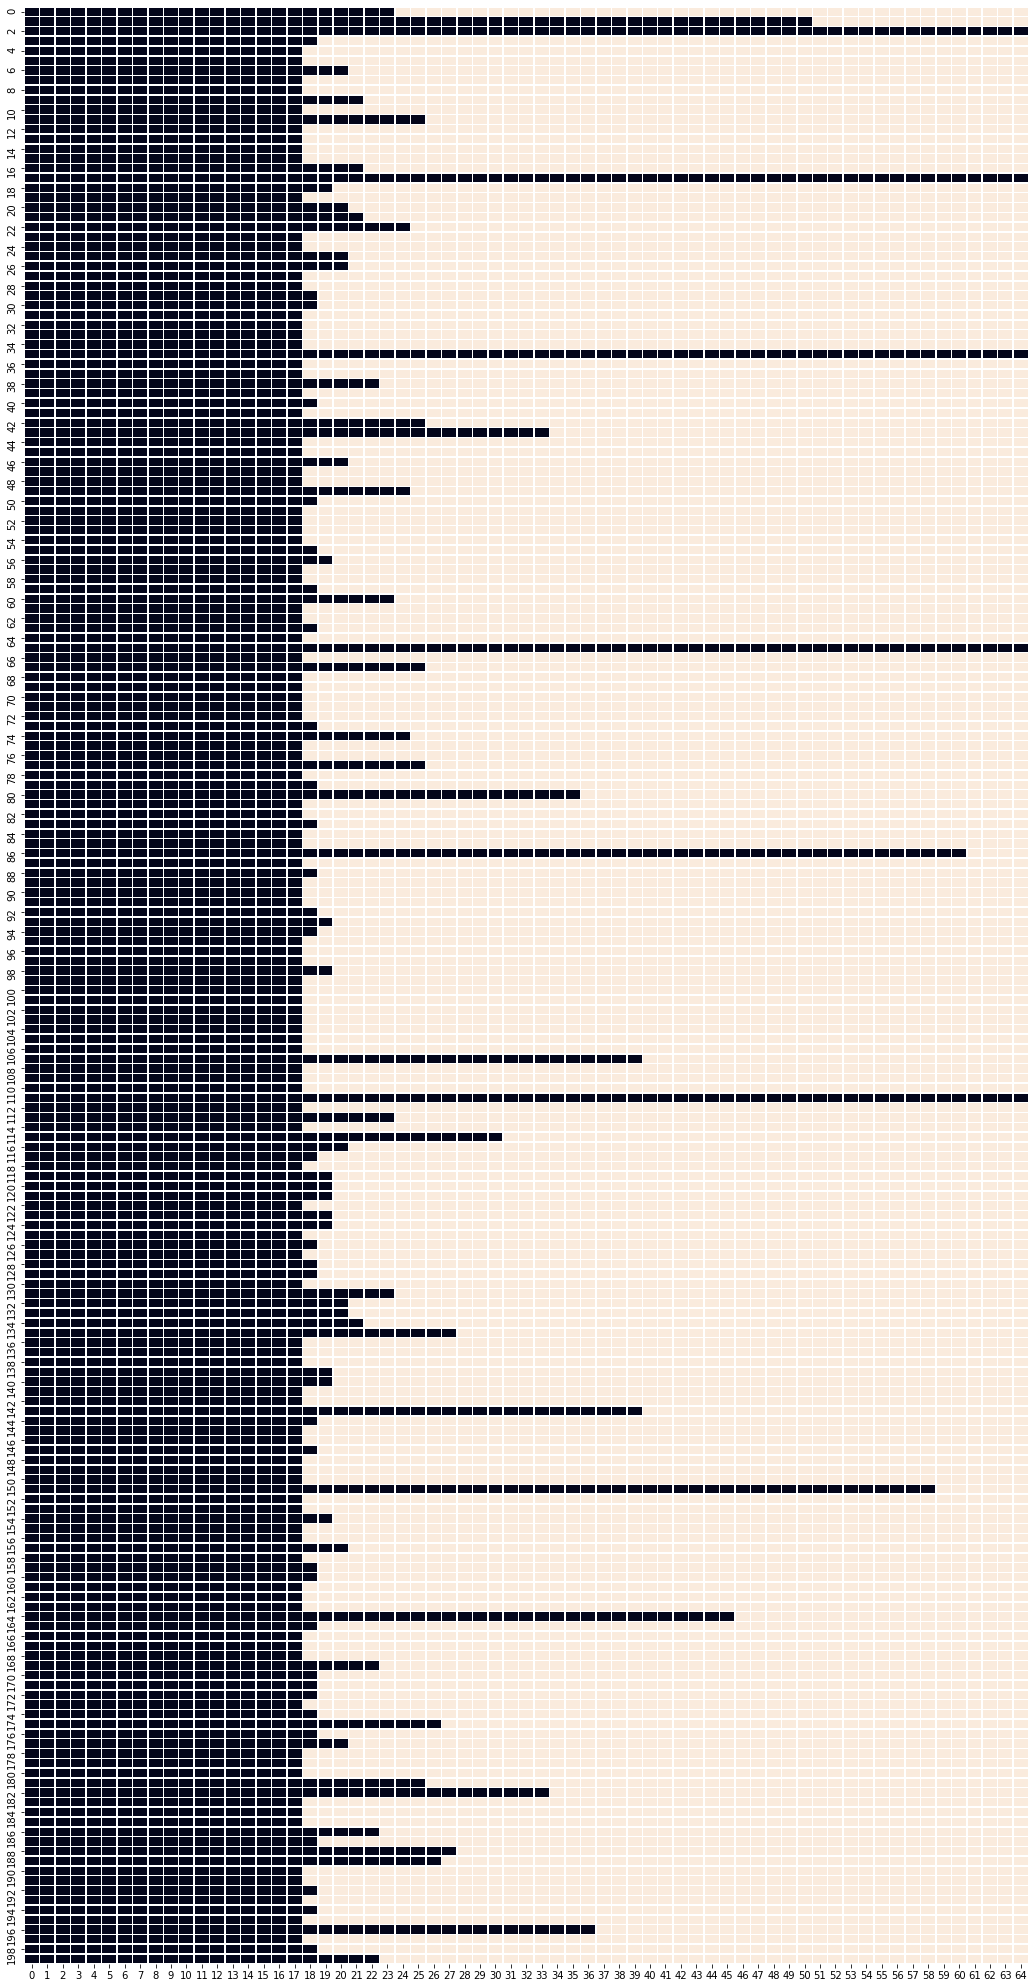

In [76]:
fig, ax = plt.subplots(nrows=1, ncols=1)
fig.set_figwidth(18)
fig.set_figheight(36)
ax = sns.heatmap(model1.samples_array[:200,:], linewidths=.5, cbar=False)

Dikarenakan contoh ini terlau rumit dan bayak asumsi yang dipertanyakan, maka kita akan menggunakan contoh kedua. Pada contoh kedua, diajukan asumsi bahwa tingkat pendidikan orang tua berhubungan positif terhadap tingkat pendidikan anak. Yang menjadi pertanyaan adalah apakah ada hubungan tingkat pendidikan antar generasi seperti hubugnan tingak pendidikan antara seorang anak dan kakeknya.

DAG yang dibat adalah seperti ini
$$
    \begin{matrix}
		G & \rightarrow & P \\
		  & \searrow & \downarrow \\
          & & C
	\end{matrix}
$$

Tapi dalam kasus ini terdapat sebuah variabel tak terobservasi sehingga DAG terlihat seperti

$$
    \begin{matrix}
		G & \rightarrow & P & \leftarrow & \mathbb{U} \\
		  & \searrow & \downarrow & \swarrow & \\
          & & C
	\end{matrix}
$$


In [108]:
n_sample = 200
b_GP = 1
b_GC = 0
b_PC = 1
b_U = 2

U = 2 * bernoulli.rvs(0.5, size=n_sample) - 1
G = norm.rvs(size = n_sample)
P = norm.rvs(size = n_sample, loc = b_GP * G + b_U * U)
C = norm.rvs(size = n_sample, loc = b_GC * G + b_U * U + b_PC * P)
df = pd.DataFrame({
    "Child": C,
    "Parent": P,
    "GrandParent": G,
    "Unobserved": U
})

In [109]:
with pm.Model() as m67:
    alpha = pm.Normal('alpha', mu=0, sd=1)
    c = pm.Normal('c', mu=0, sd=1)
    b_pc = pm.Normal('b_pc', mu=0, sd=1)
    b_gc = pm.Normal('b_gc', mu=0, sd=1)
    sigma = pm.Exponential('sigma', lam=1)
    mu = pm.Deterministic('mu', alpha + b_pc * df['Parent'] + b_gc * df['GrandParent'])
    result = pm.Normal('result', mu = mu, sd=sigma, observed=df['Child'])
    
df_trace_m67 = generate_trace_df(m67)

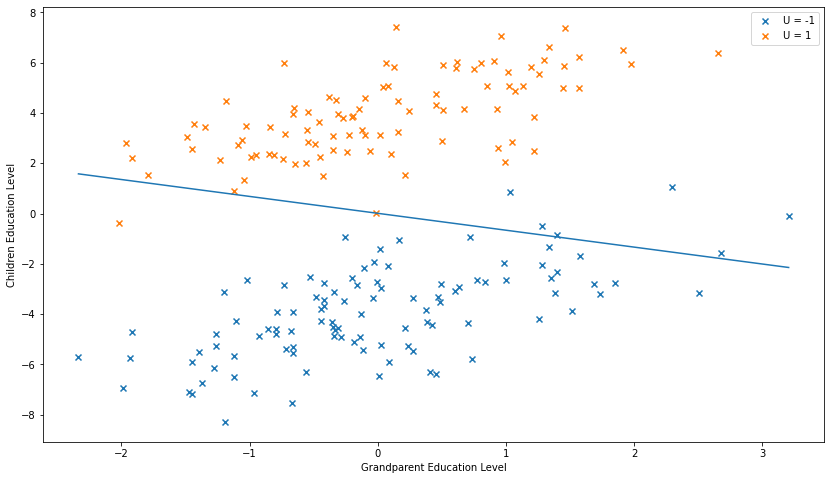

In [114]:
fig, ax = plt.subplots(nrows=1, ncols=1)
fig.set_figwidth(14)
fig.set_figheight(8)

df_unobserved_0 = df[df['Unobserved'] == -1]
df_unobserved_1= df[df['Unobserved'] == 1]

ax.scatter(df_unobserved_0['GrandParent'], df_unobserved_0['Child'], label = 'U = -1', marker='x')
ax.scatter(df_unobserved_1['GrandParent'], df_unobserved_1['Child'], label = 'U = 1', marker='x')
ax.set_ylabel("Children Education Level")
ax.set_xlabel("Grandparent Education Level")
ax.plot(df['GrandParent'].sort_values(), df_trace_m67['alpha'].mean() + df_trace_m67['b_gc'].mean() * df['GrandParent'].sort_values())
ax.legend()

In [118]:
df_trace_m67.describe()[['alpha', 'b_gc', 'b_pc']].loc[['mean', 'std']].round(2)

,alpha,b_gc,b_pc
mean,0.01,-0.67,1.78
std,0.10,0.10,0.04


Ini adalah contoh dari collider bias. Meski sudah diberikan nilai 0 pada variabel `b_GC` model menganggap relasi antara tingkat pendidikan anak berbanding terbalik dengan tingkat pendidikan kakek. Apabila diperhatikan dengan seksama, ada pemisah. Pemisah ini adalah variabel yang tidak terobsevasi tapi tetap berpengaruh terhadap tingkat pendidikan anak dan orang tua. Hal ini semakin jelas karena adanya perbedaan warna pada plot. Apabila tidak diketahui variabel $U$, maka peneliti dapat mengambil kesimpulan bahwa tingkat pendidikan kakek berbanding terbalik dengan tingkat pendidikan anak.

Plot diatas bisa dibagi ke dua klaster. Masing-masing klaster memiliki korelasi postif antara tingkat pendidikan kakek dan tingkat pendidikan anak akan tetapi dikarenakan kedua cluster tersebut digabungkan (asumsi bahwa peniliti tidak tahu variabel $U$) korelasi tersebut menjadi negatif. Solusi dari permasalahan ini adalah dengan mengetahui $U$ sehingga dapat dimasukan kedalam model.

In [119]:
with pm.Model() as m68:
    alpha = pm.Normal('alpha', mu=0, sd=1)
    c = pm.Normal('c', mu=0, sd=1)
    b_pc = pm.Normal('b_pc', mu=0, sd=1)
    b_gc = pm.Normal('b_gc', mu=0, sd=1)
    b_uc = pm.Normal('b_uc', mu=0, sd=1)
    sigma = pm.Exponential('sigma', lam=1)
    mu = pm.Deterministic('mu', alpha + b_pc * df['Parent'] + b_gc * df['GrandParent'] + b_uc * df['Unobserved'])
    result = pm.Normal('result', mu = mu, sd=sigma, observed=df['Child'])
    
df_trace_m68 = generate_trace_df(m68)
df_trace_m68.describe()[['alpha', 'b_gc', 'b_pc', 'b_uc']].loc[['mean', 'std']].round(2)

,alpha,b_gc,b_pc,b_uc
mean,0.00,0.12,0.98,1.97
std,0.07,0.09,0.06,0.14


Relasi antara tingkat pendidikan pada kakek dan tingkat pendidikan anak menjadi positif setelah variabel $U$ dimasukan menjadi salah satu prediktor model.

## Confounding

> **Confounding** dapat didefinisikan sebagai asosiasi antara variabel yang ingin diprediksi $Y$ dan variabel prediktor yang ditinjau $X$ tidak sama dengan apabila kita sudah menetukan nilai $X$ secara experimental. 

Semisal ingin dibuat penelitian yang mengasosiasikan antara gaji $W$ dan tingkat pendidikan $E$. Rumitnya kehidupan membuat ada sebuah faktor extrnal $U$ yang dapat mempengaruhi keduanya. DAG anya adalah

$$
\begin{matrix}
    U & \rightarrow & E \\
     & \searrow & \downarrow \\
     & & W
\end{matrix}
$$

Apabila dilakukan regresi $E$ terhadap $W$ maka ada campur tangan $U$ pada penarikan kesimpulan. Untuk mencegah hal ini, didefiniskan sebuat istilah bernama jejak kausal. Jejak kausal dapat difinisikan sebagai apabila relasi yang apabila diubah akan mengubah variabel tujuan. Pada kasus diatas, apabila nilai $E$ diubah maka nilai $W$ juga berubah.
Ada lagi jejak non causal. Contoh dari jejak non causal adalah $E \leftarrow U \rightarrow W$. Jejak non causal adalah yang harus dihapuskan sebelum melakukan experimen atau pembagunan model.

Bagaimana cara mengeliminasi jejak non causal? Ini dapat dikerjakan dengan mengerjakan experimen. Pada kasus diatas nilai $E$ dibuat secara random sehingga $U$ tidak memiliki pengaruh terhadap $E$. Jadi menentukan/mengkondisikan $E$ akan menhilangkan jejak non kausal. Jejak non causal akan hilang dengan cara diatas karena tidak ada lagi relasi antara $U$ dan $E$. DAG yang baru dapat dituilskan sebagai berikut.

$$
\begin{matrix}
    U &  & E \\
     & \searrow & \downarrow \\
     & & W
\end{matrix}
$$

Cara lain yang dapat dilakukan apabila $E$ tidak dapat dikondisikan ialah dengan mengondisikan $U$; menjadikan variabel tersebut terukur. Ini dapat terjadi karena apabila $U$ diketahui, maka mengetahui $E$ tidak menambah informasi apapun tentang $W$ dengan asumsi hanya ada jejak $E \leftarrow U \rightarrow W$.

Memilah milah confounding variable ini penting agar tidak tercampur mana yang berkorelasi langsung dan mana yang tidak. Variabel yang memiliki hubungan tapi tidak diinginkan dalam model disebut sebagai backdoor. Ini juga dapat membantu mengembangkan model dengan mempertimbangkan data mana saja yang harus dimasukan berdasarkan DAG yang dibuat. Salah satu tujuan DAG adalah menjelaskan confounding variable. Ada 4 tipe DAG yang harus diperhatikan karena keempat DAG ini adalah rangka dasar semua DAG.

1. Fork $A \leftarrow X \rightarrow B$
Ini sama dengan posisi variabel $U$ pada contoh sebelumnya. $A$ dan $B$ tidak tergantung antara satu dengan yang lain apabila variabel $X$ dikondisikan. 

2. Pipe $A \rightarrow X \rightarrow C$
Sama dengan fork, apabila variabel $X$ dikondisikan, maka mengetahui $A$ tidak memberi informasi mengenai $C$. Ini sama dengan contoh jamur pada post treatment bias. Apabila nilai jamurnya dikondisikan, maka mengetahui treatment tidak akan memberikan informasi tambahan mengenai laju tumbuh tumbuhan.

3. Collider $A \leftarrow X \rightarrow C$
Collider memiliki sifat kebalikan dari sebelumnya. Tidak ada asosiasi antara $A$ dan $C$ tetapi keduanya akan memiliki asosiasi apabila $X$ dikondisikan. Kemungkinan malah akan terlihat seperti fork

Untuk menutup confounding variable ini ada empat langkah yang dapat dilakukan apabila sudah memiliki DAG.

1. Cari semua jejak yang berasal dari $x$ ke $Y$
2. Tentukan apakah jejak tersebut sudah tertutup atau terbuka
3. Tentukan variabel mana yang akan dikondisikan sehingga menutup backdoor.